In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gti-upm/leapgestrecog
!unzip leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRe

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
path = "./leapGestRecog"
folders = os.listdir(path)
inner_folders = os.listdir(path+"/01")
categories=[]
for i in inner_folders:
  category = i.split('_', maxsplit=1)[1:]
  categories.append(category[0])
num_classes = len(categories)
categories

['index',
 'ok',
 'palm_moved',
 'l',
 'c',
 'thumb',
 'down',
 'fist',
 'palm',
 'fist_moved']

In [ ]:
df = pd.DataFrame(columns=['filepaths','categories'])
paths , category = [], []
for folder in folders:
  inner_folders = os.listdir(path+'/'+folder)
  for inner_f in inner_folders:
    files = os.listdir(path+'/'+folder+"/"+inner_f)
    for file in files:
      paths.append(folder+'/'+inner_f+'/'+file)
      category.append(inner_f.split('_', maxsplit=1)[1])
df['filepaths'] = paths
df['categories'] = category

In [ ]:
im_size = (224, 224)
im_width, im_height = im_size
im_channels=1
batch_size = 50

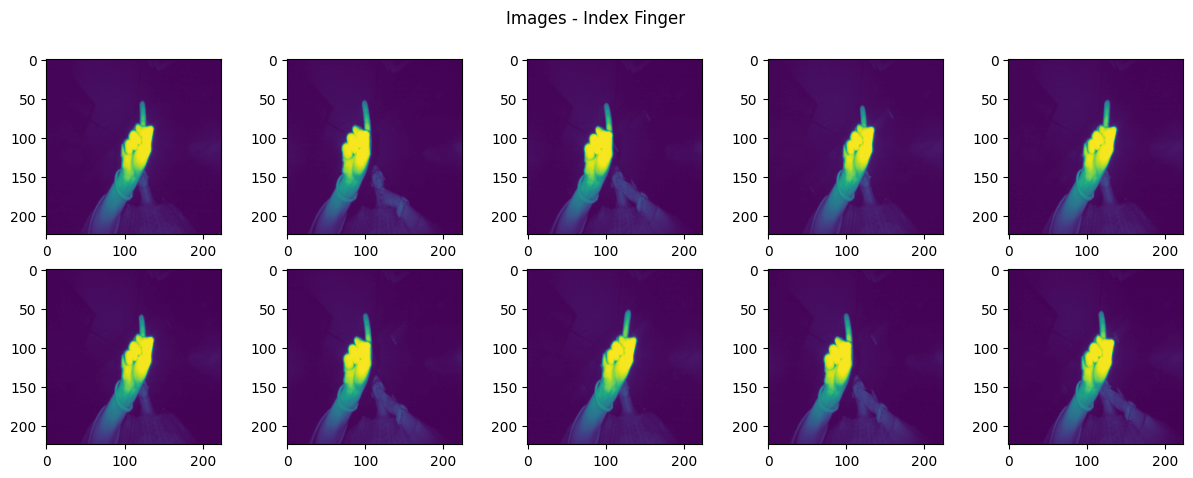

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Images - Index Finger")

for i in range(10):
  img = Image.open(path+'/'+df['filepaths'][i])
  img = img.resize(im_size)
  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  # print(img.shape)
plt.show()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=123)
train_df[:5]

,filepaths,categories
9642,03/01_palm/frame_03_01_0082.png,palm
17924,00/04_fist_moved/frame_00_04_0110.png,fist_moved
1642,09/01_palm/frame_09_01_0154.png,palm
9670,03/01_palm/frame_03_01_0140.png,palm
16860,00/09_c/frame_00_09_0138.png,c


In [ ]:
train_datagen = ImageDataGenerator(rescale=1/.255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 16000 validated image filenames belonging to 10 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale=1/.255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 2000 validated image filenames belonging to 10 classes.


## Model Definition

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(im_size[0], im_size[1], 1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (5,5), activation='relu'),
    MaxPooling2D((3,3)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction]

## Model Training

In [ ]:
model_hist = model.fit(
    train_generator,
    validation_data = val_generator,
    steps_per_epoch=100,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
100/100 [==============================] - 45s 369ms/step - loss: 5.4162 - acc: 0.1054 - val_loss: 2.3027 - val_acc: 0.0910 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 39s 389ms/step - loss: 2.3026 - acc: 0.1026 - val_loss: 2.3027 - val_acc: 0.0910 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 37s 367ms/step - loss: 2.3021 - acc: 0.1050 - val_loss: 2.2856 - val_acc: 0.1180 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 36s 361ms/step - loss: 2.2879 - acc: 0.1278 - val_loss: 2.2420 - val_acc: 0.1790 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 35s 351ms/step - loss: 2.2577 - acc: 0.1798 - val_loss: 2.2365 - val_acc: 0.1960 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 37s 367ms/step - loss: 2.2555 - acc: 0.1656 - val_loss: 2.1759 - val_acc: 0.2210 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 38s 380ms/step - loss: 2.2062 - acc: 0.1976 - val_l

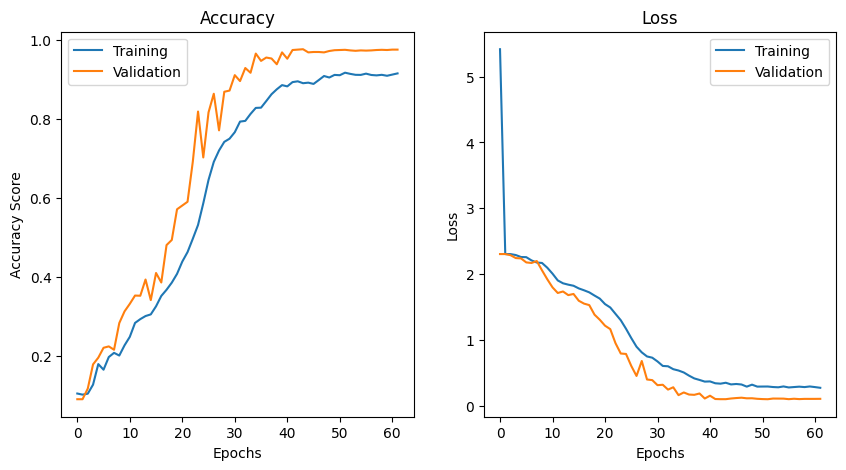

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(model_hist.history['acc'], label='Training')
plt.plot(model_hist.history['val_acc'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_hist.history['loss'], label='Training')
plt.plot(model_hist.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.savefig("Training History.jpg")
plt.show()

In [ ]:
model.save('hand_gesture_recognition.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation

In [ ]:
basic_test_generator = train_datagen.flow_from_dataframe(
    test_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 2000 validated image filenames belonging to 10 classes.


In [ ]:
loss, acc = model.evaluate(basic_test_generator)
print("Testing Loss:", loss)
print("Testing Accuracy:", acc)

40/40 [==============================] - 12s 297ms/step - loss: 0.1325 - acc: 0.9625
Testing Loss: 0.1325465440750122
Testing Accuracy: 0.9624999761581421


## Inference

In [ ]:
from PIL import Image

In [ ]:
test_df[40:48]

,filepaths,categories
4662,04/02_l/frame_04_02_0013.png,l
13352,01/10_down/frame_01_10_0111.png,down
13647,01/01_palm/frame_01_01_0018.png,palm
5615,04/01_palm/frame_04_01_0022.png,palm
17957,00/04_fist_moved/frame_00_04_0001.png,fist_moved
15652,06/01_palm/frame_06_01_0053.png,palm
9179,03/05_thumb/frame_03_05_0031.png,thumb
5668,04/01_palm/frame_04_01_0116.png,palm


In [ ]:
sample_imgs=[]
for img_paths in test_df[100:108]['filepaths']:
  img = Image.open(path+'/'+img_paths)
  img = img.resize(im_size)
  img = img.convert('L')
  img = np.array(img)
  img = img.reshape((img.shape[0], img.shape[1], 1))
  sample_imgs.append(img)
sample_imgs = np.array(sample_imgs)
sample_imgs.shape

(8, 224, 224, 1)

In [ ]:
preds = model.predict(sample_imgs)
preds = np.argmax(preds, axis=1)

1/1 [==============================] - 0s 423ms/step


In [ ]:
preds

array([0, 8, 0, 8, 0, 8, 2, 4])

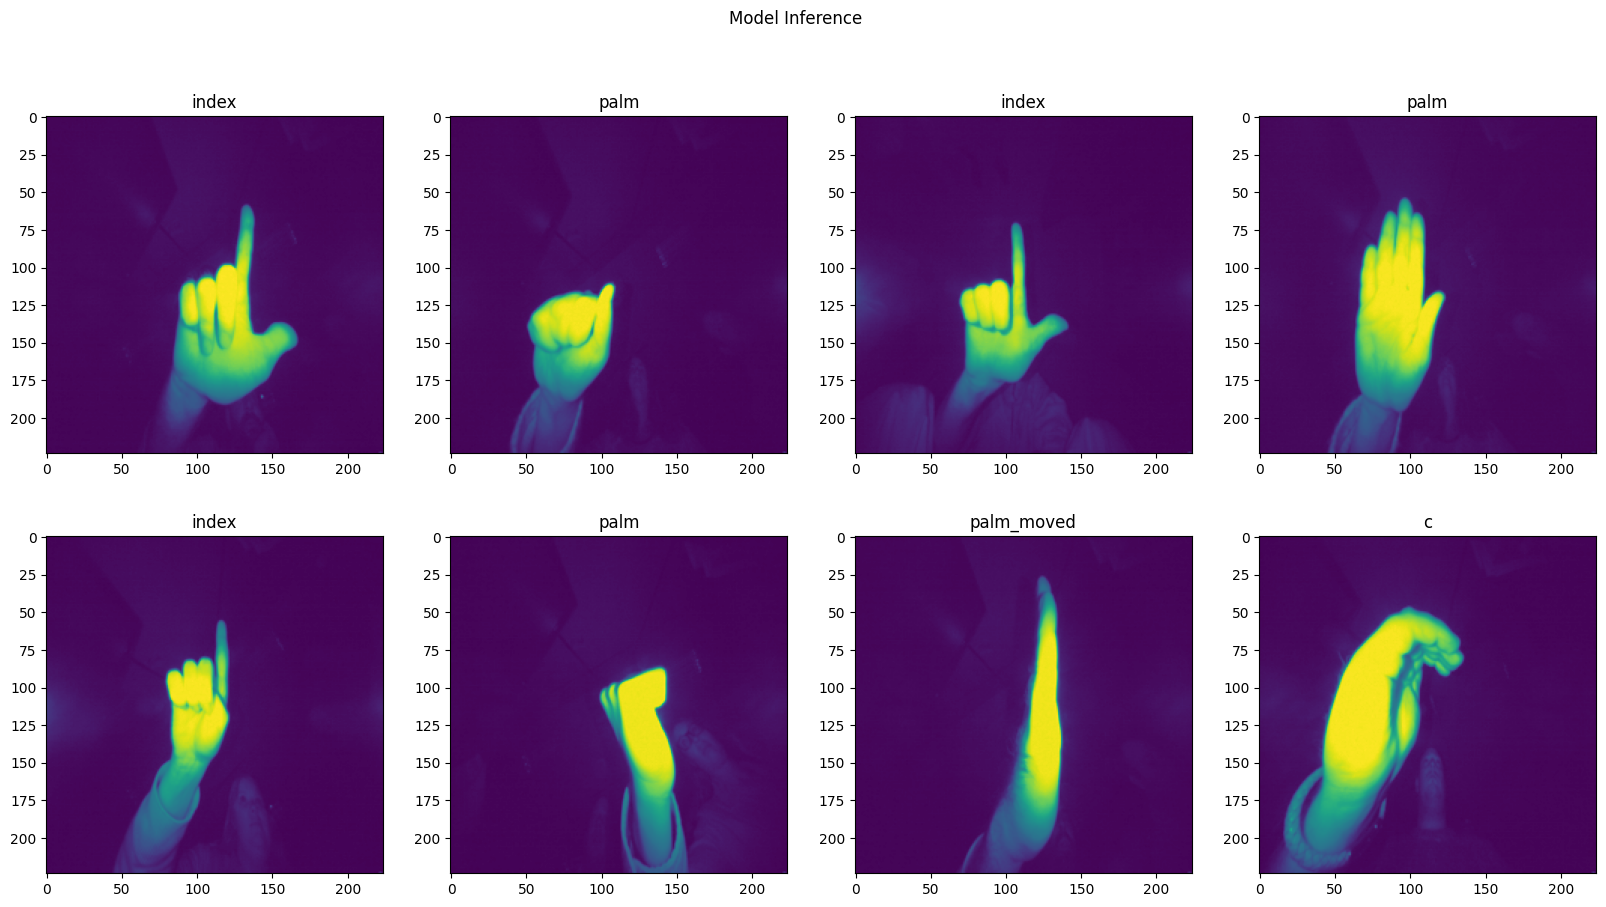

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Model Inference")
ind=1
for img in sample_imgs:
  plt.subplot(2,4,ind)
  plt.imshow(img)
  plt.title(categories[preds[ind-1]])
  ind+=1
plt.savefig("Hand Gesture model Inference.jpg")
plt.show()